In [1]:
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd
import re
import numpy as np
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.losses import mean_squared_error

In [4]:
%cd /content/drive/MyDrive/703_Project/LSTM/

/content/drive/MyDrive/703_Project/LSTM


**Create combined csv files**





In [ ]:
"""
def process_folder(main_folder_path, group_label):
   Traite tous les fichiers CSV dans un dossier et retourne un DataFrame fusionné.
    frames = []  # Liste pour stocker les DataFrames de chaque fichier
    for subdir, dirs, files in os.walk(main_folder_path):
      for filename in files:
        if filename.endswith('.csv'):
            file_path = os.path.join(subdir, filename)
            df = pd.read_csv(file_path)
            df['conversation_id'] = filename.split('.')[0]  # Utilisez le nom du fichier comme ID
            df['group'] = group_label
            df = df[['text', 'conversation_id', 'group']]
            frames.append(df)
    return pd.concat(frames)

# Chemins des dossiers pour les fichiers CSV des groupes contrôle et patient
control_main_folder_path = "Control_csv_data_clean"
patient_main_folder_path = "Patient_csv_data_clean"

# Traitement des dossiers et fusion des DataFrames
control_df = process_folder(control_main_folder_path, 'control')
patient_df = process_folder(patient_main_folder_path, 'patient')
combined_df = pd.concat([control_df, patient_df])

# Enregistrement du DataFrame fusionné dans un nouveau fichier CSV
combined_df.to_csv('combined_control_patient_data.csv', index=False)
"""

**Step 1 : data split and preprocessing**

In [ ]:
# Charger les données
data = pd.read_csv('combined_control_patient_data.csv')
data_df = pd.DataFrame(data)

# Fonction de nettoyage des données textuelles
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9']", " ", text)  # Supprimer les caractères non alphanumériques
    text = re.sub(r"\s+", " ", text)  # Supprimer les espaces supplémentaires
    return text

# Nettoyage du texte
data_df['text'] = data_df['text'].apply(clean_text)


# Fonction pour calculer le score de sentiment
def sentiment_score(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Retourne un score entre -1 et 1

# Appliquer la fonction à chaque réponse
data_df['sentiment'] = data_df['text'].apply(sentiment_score)

# Groupement des données par conversation_id
conversation_ids = data['conversation_id'].unique()
np.random.shuffle(conversation_ids)

# Division des identifiants de conversation
train_size = int(0.8 * len(conversation_ids))
val_size = int(0.1 * len(conversation_ids))

train_ids = conversation_ids[:train_size]
val_ids = conversation_ids[train_size:train_size + val_size]
test_ids = conversation_ids[train_size + val_size:]

# Sélection des ensembles d'entraînement, de validation et de test
train_df = data[data['conversation_id'].isin(train_ids)]
val_df = data[data['conversation_id'].isin(val_ids)]
test_df = data[data['conversation_id'].isin(test_ids)]

# Tokenisation et Padding
tokenizer = Tokenizer(num_words=12400)
tokenizer.fit_on_texts(data['text'])

# Fonction pour tokeniser et pad un DataFrame
max_seq_length = 15
def prepare_data(df):
    sequences = tokenizer.texts_to_sequences(df['text'])
    return pad_sequences(sequences, maxlen=max_seq_length)

# Préparation des données
X_train_padded = prepare_data(train_df)
y_train = train_df['sentiment'].values

X_val_padded = prepare_data(val_df)
y_val = val_df['sentiment'].values

X_test_padded = prepare_data(test_df)
y_test = test_df['sentiment'].values

"""
# Ici, 'sentiment' est la colonne des labels que nous venons de créer
y = data_df['sentiment'].values

# Division des données tout en conservant les identifiants de conversation
X_train, X_temp, y_train, y_temp, ids_train, ids_temp = train_test_split(data_df.drop(columns=['sentiment']), data_df['sentiment'], data_df['conversation_id'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test, ids_val, ids_test = train_test_split(X_temp, y_temp, ids_temp, test_size=0.5, random_state=42)

# Préparation de la tokenisation
tokenizer = Tokenizer(num_words=12400)  # Limite à 12400 mots
tokenizer.fit_on_texts(data_df['text'])

sequences = tokenizer.texts_to_sequences(data_df['text'])


# Tokenization et Padding des ensembles
max_seq_length = 15  # Ajuster selon la longueur désirée
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train['text']), maxlen=max_seq_length)
X_val_padded = pad_sequences(tokenizer.texts_to_sequences(X_val['text']), maxlen=max_seq_length)
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test['text']), maxlen=max_seq_length)
"""

In [ ]:
#print(data_df.head(10))

In [ ]:
#print (data_df['group'].unique())

In [ ]:
"""
data_sample_df['text'] = data_sample_df['text'].apply(clean_text)
sample_sequences = tokenizer.texts_to_sequences(data_sample_df['text'])
sample_padded = pad_sequences(sample_sequences, maxlen=max_seq_length)
"""

In [ ]:
"""
# examiner les séquences tokenisées et les longueurs de séquence
for i in range(5):
    print(f"Texte original: {data['text'].iloc[i]}")
    print(f"Séquence tokenisée: {sequences[i]}")
    print(f"Longueur de la séquence: {len(sequences[i])}\n")
"""

**How to get num_words and max_seq_length**

In [6]:
# Tokenizer sans limiter le nombre de mots
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_df['text'])

# Nombre total de mots uniques
word_count = len(tokenizer.word_index)
print(f"Nombre total de mots uniques dans le jeu de données : {word_count}")

Nombre total de mots uniques dans le jeu de données : 12385


In [7]:
text_lengths = [len(text.split()) for text in data_df['text']]
print(f"Moyenne: {np.mean(text_lengths)}")
print(f"Médiane: {np.median(text_lengths)}")
print(f"Percentile 90: {np.percentile(text_lengths, 90)}")

Moyenne: 7.460360360360361
Médiane: 6.0
Percentile 90: 15.0


**Verifications**

In [8]:
# Vérification des dimensions pour l'entraînement du modèle

print(f"Dimensions de X_train_padded: {X_train_padded.shape}")
print(f"Dimensions de y_train: {y_train.shape}")
print(f"Dimensions de X_test_padded: {X_test_padded.shape}")
print(f"Dimensions de y_test: {y_test.shape}")
print(f"Dimensions de X_val_padded: {X_val_padded.shape}")
print(f"Dimensions de y_val: {y_val.shape}")

Dimensions de X_train_padded: (63201, 15)
Dimensions de y_train: (63201,)
Dimensions de X_test_padded: (6793, 15)
Dimensions de y_test: (6793,)
Dimensions de X_val_padded: (8816, 15)
Dimensions de y_val: (8816,)


In [9]:
print(f"Dimensions de ids_train: {train_ids.shape}")
print(f"Dimensions de ids_val: {val_ids.shape}")
print(f"Dimensions de ids_test: {test_ids.shape}")

Dimensions de ids_train: (357,)
Dimensions de ids_val: (44,)
Dimensions de ids_test: (46,)


**Step 2 : Word Embeddings preparation**

In [10]:
# Chargement des embeddings GloVe
EMBEDDING_DIM = 100  # Par exemple, pour GloVe 6B avec des vecteurs de 100 dimensions
embedding_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Préparation de la matrice d'embedding
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Création de la couche d'embedding en utilisant la matrice d'embedding
embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_seq_length,
                            trainable=False)

In [11]:
#contrôler la matrice d'embedding
print("Dimensions de la matrice d'embedding:", embedding_matrix.shape)

Dimensions de la matrice d'embedding: (12386, 100)


**Verifications**

In [ ]:
# Tokenizer Vocabulary
for word, index in tokenizer.word_index.items():
    print(f"Mot : {word}, Index : {index}")
    if index == 100:  # Afficher les 10 premiers mots
        break


In [ ]:
# Correspondence in the Embedding Matrix
for word, index in tokenizer.word_index.items():
    if word in embedding_index:
        print(f"Le mot '{word}' est dans GloVe.")
    else:
        print(f"Le mot '{word}' n'est pas dans GloVe.")
    if index == 100:  # Vérifier pour les 10 premiers mots
        break


In [14]:
# Coverage %
total_mots = len(tokenizer.word_index)
mots_dans_glove = sum(1 for word in tokenizer.word_index if word in embedding_index)
pourcentage_couverture = (mots_dans_glove / total_mots) * 100
print(f"Pourcentage de mots du tokeniseur couverts par GloVe : {pourcentage_couverture}%")


Pourcentage de mots du tokeniseur couverts par GloVe : 89.01897456600727%


**Step 3 : LSTM model**

In [15]:
# Création du modèle LSTM
model = Sequential()
model.add(embedding_layer)  # Utilisez la couche d'embedding préparée précédemment
model.add(LSTM(64, return_sequences=False))  # return_sequences=False pour la dernière couche LSTM
model.add(Dropout(0.5))
model.add(Dense(1, activation='tanh'))  # Score de sentiment entre -1 et 1

model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
"""
grouped = data.groupby('conversation_id')  # Groupez par ID de conversation
X = []

for _, group in grouped:
    # Tokenisez et paddez chaque réponse dans la conversation
    sequences = tokenizer.texts_to_sequences(group['text'])
    padded_sequences = pad_sequences(sequences, maxlen=max_seq_length)
    X.append(padded_sequences)

y = []

for _, group in grouped:
    sentiment_scores = group['sentiment'].values  # Scores de sentiment pour la conversation
    y.append(sentiment_scores)

print(y)
"""

**Step 4 : Model training**

In [33]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Entraînement du modèle avec Early Stopping
model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_val_padded, y_val), callbacks=[early_stopping])


Epoch 1/10
1976/1976 [==============================] - 28s 14ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 2/10
1976/1976 [==============================] - 30s 15ms/step - loss: 0.0081 - val_loss: 0.0082
Epoch 3/10
1976/1976 [==============================] - 28s 14ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 4/10
1976/1976 [==============================] - 26s 13ms/step - loss: 0.0072 - val_loss: 0.0078
Epoch 5/10
1976/1976 [==============================] - 29s 15ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 6/10
1976/1976 [==============================] - 34s 17ms/step - loss: 0.0065 - val_loss: 0.0074
Epoch 7/10
1976/1976 [==============================] - 35s 18ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 8/10
1976/1976 [==============================] - 33s 17ms/step - loss: 0.0061 - val_loss: 0.0070
Epoch 9/10
1976/1976 [==============================] - 31s 16ms/step - loss: 0.0058 - val_loss: 0.0066
Epoch 10/10
1976/1976 [==============================] - 34s 17m

**Step 5 : Results analysis**

In [34]:
# Évaluation du Modèle sur l'Ensemble de Test
test_loss = model.evaluate(X_test_padded, y_test)
print(f"Perte sur l'ensemble de test: {test_loss}")


213/213 [==============================] - 1s 7ms/step - loss: 0.0058
Perte sur l'ensemble de test: 0.005824749357998371


In [35]:
# Prédiction des Sentiments sur l'Ensemble de Test
pred_sentiment = model.predict(X_test_padded)

213/213 [==============================] - 1s 6ms/step


In [36]:
# Créer un DataFrame pour associer les prédictions aux conversations
test_df['predicted_sentiment'] = pred_sentiment.flatten()

# Grouper par conversation_id
conversations = test_df.groupby('conversation_id')
evolution_sentiments = {}

for conversation_id, group in conversations:
    sentiment_debut = group['predicted_sentiment'].iloc[0]
    sentiment_fin = group['predicted_sentiment'].iloc[-1]
    evolution_sentiments[conversation_id] = sentiment_fin - sentiment_debut

evolutions_patient = [evolution_sentiments[cid] for cid, group in conversations if group['group'].iloc[0] == 'patient']
evolutions_patient
evolutions_control = [evolution_sentiments[cid] for cid, group in conversations if group['group'].iloc[0] == 'control']

<ipython-input-36-da7b2f64de48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_sentiment'] = pred_sentiment.flatten()


In [20]:
test_df.columns

Index(['text', 'conversation_id', 'group', 'sentiment', 'predicted_sentiment'], dtype='object')

In [21]:
test_df.to_csv('test_df2.csv', index="False")

**Variation totale du sentiment**

In [46]:
variation_totale = {}
nombre_conversations_patient = 0
nombre_conversations_controle = 0

for conversation_id, group in conversations:
    variation = group['predicted_sentiment'].iloc[-1] - group['predicted_sentiment'].iloc[0]
    variation_totale[conversation_id] = variation

    # Compter le nombre de conversations pour chaque groupe
    if group['group'].iloc[0] == 'patient':
        nombre_conversations_patient += 1
    elif group['group'].iloc[0] == 'control':
        nombre_conversations_controle += 1

print("Variations Totales par Conversation:", variation_totale)
print("Nombre de Conversations - Patient:", nombre_conversations_patient)
print("Nombre de Conversations - Control:", nombre_conversations_controle)


Variations Totales par Conversation: {'46-1': -0.015379535, '47-2': -0.7907433, '60-1': -0.43510494, '64-2': -0.76209766, '65-1': -0.29867128, '73-2': -0.01067391, 'Baycrest12370a': -0.85209215, 'UMD08': 0.62700987, 'UMD14': 0.20308176, 'UMD17': 0.015387378, 'adler05a': -0.7606561, 'adler08a': 0.5171664, 'adler09a': -0.51097935, 'adler20a': -0.028781548, 'kurland02a': 0.5189428, 'kurland02g': -0.29978436, 'kurland08c': 0.01766279, 'kurland15e': -0.0029013078, 'kurland18b': -0.522524, 'kurland18d': -0.543969, 'kurland24a': -0.02016129, 'kurland26a': -0.55034816, 'scale05a': -0.027502293, 'scale06b': -0.8999462, 'scale11b': -0.015307053, 'scale15a': -0.5204405, 'scale15c': 0.0013990006, 'scale30a': -0.523436, 'scale35a': 0.5123235, 'tucson04a': -0.53681517, 'tucson08a': -0.007984592, 'tucson11a': -0.06428915, 'williamson19a': -0.0050425045, 'wright09a': -0.24133806, 'wright11a': -0.14129809, 'wright12a': -0.045489334, 'wright21a': 0.061972685, 'wright23a': -0.46019736, 'wright26a': -0.48

In [ ]:
variation_totale = {}
for conversation_id, group in conversations:
    variation_totale[conversation_id] = group['predicted_sentiment'].iloc[-1] - group['predicted_sentiment'].iloc[0]

variation_totale

In [47]:
# Initialisation des variables pour accumuler les variations
variation_totale_patient = []
variation_totale_controle = []

for conversation_id, group in conversations:
    # Calcul de la variation du sentiment pour la conversation
    variation = group['predicted_sentiment'].iloc[-1] - group['predicted_sentiment'].iloc[0]

    # Ajout de la variation au groupe approprié
    if group['group'].iloc[0] == 'patient':
        variation_totale_patient.append(variation)
    elif group['group'].iloc[0] == 'control':
        variation_totale_controle.append(variation)

# Calcul des moyennes
moyenne_variation_patient = np.mean(variation_totale_patient)
moyenne_variation_controle = np.mean(variation_totale_controle)

print(f"Moyenne de la variation pour les patients: {moyenne_variation_patient}")
print(f"Moyenne de la variation pour les contrôles: {moyenne_variation_controle}")


Moyenne de la variation pour les patients: -0.22710499167442322
Moyenne de la variation pour les contrôles: -0.06737012416124344


**Visualisation graphique**

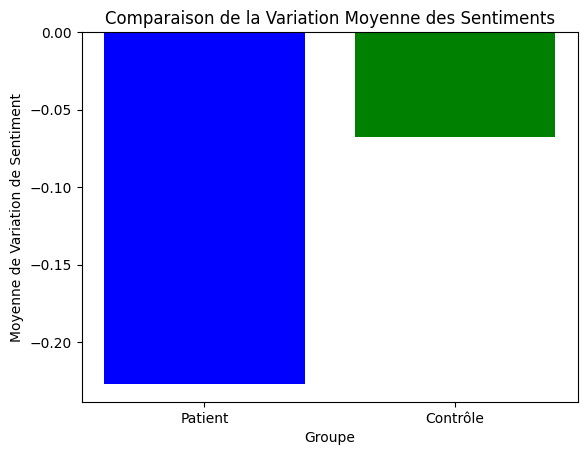

In [39]:
import matplotlib.pyplot as plt

# Valeurs pour la visualisation
groupes = ['Patient', 'Contrôle']
valeurs = [moyenne_variation_patient, moyenne_variation_controle]

plt.bar(groupes, valeurs, color=['blue', 'green'])
plt.xlabel('Groupe')
plt.ylabel('Moyenne de Variation de Sentiment')
plt.title('Comparaison de la Variation Moyenne des Sentiments')
plt.show()

**Static analysis**

In [41]:
variation_patient_sqrt = np.sqrt(np.array(variation_totale_patient) + 1)


In [42]:
shapiro_test_patient_transformed = stats.shapiro(variation_patient_sqrt)  # Ou variation_patient_box_cox, variation_patient_sqrt
print(f"Shapiro Test après transformation: Statistique={shapiro_test_patient_transformed[0]}, p-value={shapiro_test_patient_transformed[1]}")


Shapiro Test après transformation: Statistique=0.9239652156829834, p-value=0.038470104336738586


In [40]:
# check the normality
import scipy.stats as stats

# Test de Shapiro-Wilk pour vérifier la normalité
# Pour le groupe patient
shapiro_test_patient = stats.shapiro(variation_totale_patient)
print(f"Shapiro Test pour le groupe patient: Statistique={shapiro_test_patient[0]}, p-value={shapiro_test_patient[1]}")

# Pour le groupe contrôle
shapiro_test_controle = stats.shapiro(variation_totale_controle)
print(f"Shapiro Test pour le groupe contrôle: Statistique={shapiro_test_controle[0]}, p-value={shapiro_test_controle[1]}")


Shapiro Test pour le groupe patient: Statistique=0.9153380393981934, p-value=0.02326894737780094
Shapiro Test pour le groupe contrôle: Statistique=0.9449255466461182, p-value=0.3813399374485016


In [43]:
#check the homogeneity of variances
from scipy.stats import levene

# Test de Levene pour vérifier l'homogénéité des variances
stat, p_value = levene(variation_totale_patient, variation_totale_controle)

print(f"Test de Levene: Statistique={stat}, p-value={p_value}")

# variances are equal

Test de Levene: Statistique=0.3652226088628668, p-value=0.5487236654740284


In [49]:
from scipy.stats import ttest_ind

# Effectuer un test t pour échantillons indépendants
t_stat, p_value = ttest_ind(variation_totale_patient, variation_totale_controle)

print(f"Test t pour échantillons indépendants: Statistique t={t_stat}, p-value={p_value}")

#p-value > 0.05 --> the difference between the means of the two groups is not statistically significant


Test t pour échantillons indépendants: Statistique t=-1.3341225484711228, p-value=0.1890279708346075


**Variation Moyenne du Sentiment**

In [ ]:
variation_moyenne = {}
for conversation_id, group in conversations:
    variations = group['predicted_sentiment'].diff().abs()
    variation_moyenne[conversation_id] = variations.mean()

variation_moyenne

**Analyse de la dispersion des sentiments**

In [ ]:
ecart_type_sentiment = {}
for conversation_id, group in conversations:
    ecart_type_sentiment[conversation_id] = group['predicted_sentiment'].std()
ecart_type_sentiment

**Test sample**